# Soil Tutorial

## Introduction

This notebook is an introduction to the soil agent-based social network simulation framework.
In particular, we will focus on a specific use case: studying the propagation of news in a social network.

The steps we will follow are:

* Modelling the behavior of agents
* Running the simulation using different configurations
* Analysing the results of each simulation

But before that, let's import the soil module and networkx.

In [1]:
import soil
import networkx as nx
 
%load_ext autoreload
%autoreload 2

%matplotlib inline
# To display plots in the notebooed_

## Basic concepts

There are three main elements in a soil simulation:
    
* The network topology. A simulation may use an existing NetworkX topology, or generate one on the fly
* Agents. There are two types: 1) network agents, which are linked to a node in the topology, and 2) environment agents, which are freely assigned to the environment.
* The environment. It assigns agents to nodes in the network, and stores the environment parameters (shared state for all agents).

Soil is based on ``simpy``, which is an event-based network simulation library.
Soil provides several abstractions over events to make developing agents easier.
This means you can use events (timeouts, delays) in soil, but for the most part we will assume your models will be step-based.


## Modeling behaviour

Our first step will be to model how every person in the social network reacts when it comes to news.
We will follow a very simple model (a finite state machine).

There are two types of people, those who have heard about a newsworthy event (infected) or those who have not (neutral).
A neutral person may heard about the news either on the TV (with probability **prob_tv_spread**) or through their friends.
Once a person has heard the news, they will spread it to their friends (with a probability **prob_neighbor_spread**).
Some users do not have a TV, so they only rely on their friends.

The spreading probabilities will change over time due to different factors.
We will represent this variance using an environment agent.

### Network Agents

A basic network agent in Soil would typically inherit from ``soil.agents.NetworkAgent``, and define its behaviour in every step of the simulation by implementing a ``run(self)`` method.
The most important attributes of the agent are:

* ``agent.state``, a dictionary with the state of the agent. This tate will be saved in every step of the simulation. It can be accessed from the agent as well:
```py
a = soil.agents.NetworkAgent(env=env)
agent.state['hours_of_sleep'] = 10
# is the same as
a['hours_of_sleep'] = 10
```
  The state of the agent is stored in every step of the simulation:
  ```py
  print(a['hours_of_sleep', 10]) # hours of sleep before step #10
  print(a[None, 0]) # whole state of the agent before step #0
  ```

* ``agent.env``, a reference to the environment. Most commonly used to get access to the environment parameters and the topology:
    ```py
    a.env.G.nodes() # Get all nodes ids in the topology
    a.env['minimum_hours_of_sleep']

    ```

Since our model is a finite state machine, we will be basing it on ``soil.agents.FSM``.

Agents that inherit from ``soil.agents.FSM`` do not need to specify a ``step`` method.
Instead, we describe each finite state with a function.
To change to another state, a function may return the new state, or the ``id`` of a state.
If no state is returned, the state remains unchanged.

The current state of the agent can be checked with ``agent.state['id']``. That state id can be used to look for other networks in that specific state


Our agent will have of two states, ``neutral`` (default) and ``infected``.

Here's the code:

In [2]:
import random

class NewsSpread(soil.agents.FSM):
    @soil.agents.default_state
    @soil.agents.state
    def neutral(self):
        r = random.random()
        if self['has_tv'] and r <= self.env['prob_tv_spread']:
                return self.infected
        return
    
    @soil.agents.state
    def infected(self):
        prob_infect = self.env['prob_neighbor_spread']
        for neighbor in self.get_neighboring_agents(state_id=self.neutral.id):
            r = random.random()
            if r < prob_infect:
                neighbor.set_state(self.infected.id)
        return
        

### Environment agents

Environment agents allow us to control the state of the environment.
In this case, we will use an environment agent to simulate a very viral event.

When the event happens, the agent will modify the probability of spreading the rumor.

In [3]:
NEIGHBOR_FACTOR = 0.9
TV_FACTOR = 0.5


class NewsEnvironmentAgent(soil.agents.NetworkAgent):
    def step(self):
        if self.now == self['event_time']:
            self.env['prob_tv_spread'] = 1
            self.env['prob_neighbor_spread'] = 1
        elif self.now > self['event_time']:
            self.env['prob_tv_spread'] = self.env['prob_tv_spread'] * TV_FACTOR
            self.env['prob_neighbor_spread'] = self.env['prob_neighbor_spread'] * NEIGHBOR_FACTOR

### Testing the agents

Feel free to skip this section if this is your first time with soil.

Testing agents is not easy, and this is not a thorough testing process for agents.
Rather, this section is aimed to show you how to access internal pats of soil so you can test your agents.

First of all, let's check if our network agent has the states we would expect:

In [4]:
NewsSpread.states

{'neutral': <function __main__.NewsSpread.neutral(self)>,
 'infected': <function __main__.NewsSpread.infected(self)>}

Now, let's run a simulation on a simple network. It is comprised of three nodes:


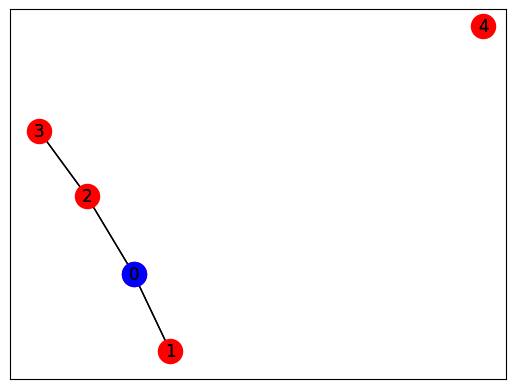

In [5]:
G = nx.Graph()
G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(2, 3)
G.add_node(4)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color='red')
nx.draw_networkx(G, pos, nodelist=[0], node_color='blue')

Let's run a simple simulation that assigns a NewsSpread agent to all the nodes in that network.
Notice how node 0 is the only one with a TV.

In [6]:
import importlib
importlib.reload(soil.agents)

<module 'soil.agents' from '/mnt/data/home/j/git/lab.gsi/soil/soil/soil/agents/__init__.py'>

In [7]:
env_params = {
    'prob_tv_spread': 0,
    'prob_neighbor_spread': 0
}

MAX_TIME = 100
EVENT_TIME = 10

sim = soil.Simulation(topology=G,
                      num_trials=1,
                      max_time=MAX_TIME,
                      environment_agents=[{'agent_type': NewsEnvironmentAgent,
                                           'state': {
                                           'event_time': EVENT_TIME
                                         }}],
                      network_agents=[{'agent_type': NewsSpread,
                                      'weight': 1}],
                      states={0: {'has_tv': True}},
                      default_state={'has_tv': False},
                      environment_params=env_params)
env = sim.run_simulation(dry_run=True)[0]

Now we can access the results of the simulation and compare them to our expected results

In [8]:
agents = list(env.network_agents)

# Until the event, all agents are neutral
for t in range(10):
    for a in agents:
        assert a['state_id', t] == a.neutral.id
        
# After the event, the node with a TV is infected, the rest are not
assert agents[0]['has_tv']
assert agents[0]['state_id', 11] == NewsSpread.infected.id
assert not agents[2]['has_tv']
assert agents[2]['state_id', 11] == NewsSpread.neutral.id


# At the end, the agents connected to the infected one will probably be infected, too.
assert agents[1]['state_id', MAX_TIME] == NewsSpread.infected.id
assert agents[2]['state_id', MAX_TIME] == NewsSpread.infected.id

# But the node with no friends should not be affected
assert agents[4]['state_id', MAX_TIME] == NewsSpread.neutral.id
        

Lastly, let's see if the probabilities have decreased as expected:

In [9]:
assert abs(env.environment_params['prob_neighbor_spread'] - (NEIGHBOR_FACTOR**(MAX_TIME-1-10))) < 10e-4
assert abs(env.environment_params['prob_tv_spread'] - (TV_FACTOR**(MAX_TIME-1-10))) < 10e-6

## Running the simulation

To run a simulation, we need a configuration.
Soil can load configurations from python dictionaries as well as JSON and YAML files.
For this demo, we will use a python dictionary:

In [10]:
config = {
    'name': 'ExampleSimulation',
    'max_time': 20,
    'interval': 1,
    'num_trials': 1,
    'network_params': {
       'generator': 'complete_graph',
        'n': 500,
    },
    'network_agents': [
        {
            'agent_type': NewsSpread,
            'weight': 1,
            'state': {
                'has_tv': False
            }
        },
        {
            'agent_type': NewsSpread,
            'weight': 2,
            'state': {
                'has_tv': True
            }
        }
    ],
    'environment_agents':[
        {'agent_type': NewsEnvironmentAgent,
         'state': {
             'event_time': 10
         }
        }
    ],
    'states': [ {'has_tv': True} ],
    'environment_params':{
        'prob_tv_spread': 0.01,
        'prob_neighbor_spread': 0.5
    }
}

Let's run our simulation:

In [11]:
soil.simulation.run_from_config(config, dry_run=True)

In real life, you probably want to run several simulations, varying some of the parameters so that you can compare and answer your research questions.

For instance:
    
* Does the outcome depend on the structure of our network? We will use different generation algorithms to compare them (Barabasi-Albert and Erdos-Renyi)
* How does neighbor spreading probability affect my simulation? We will try probability values in the range of [0, 0.4], in intervals of 0.1.

In [12]:
network_1 = {
       'generator': 'erdos_renyi_graph',
        'n': 500,
        'p': 0.1
}
network_2 = {
       'generator': 'barabasi_albert_graph',
        'n': 500,
        'm': 2
}


for net in [network_1, network_2]:
    for i in range(5):
        prob = i / 10
        config['environment_params']['prob_neighbor_spread'] = prob
        config['network_params'] = net
        config['name'] = 'Spread_{}_prob_{}'.format(net['generator'], prob)
        s = soil.simulation.run_from_config(config, exporters=['default', 'csv'])

The results are conveniently stored in sqlite (history of agent and environment state) and the configuration is saved in a YAML file.

You can also export the results to GEXF format (dynamic network) and CSV using .`run_from_config(config, dump=['gexf', 'csv'])` or the command line flags `--graph --csv`.

In [13]:
!tree soil_output
!du -xh soil_output/*

soil_output
├── Spread_barabasi_albert_graph_prob_0.0
│   ├── backup
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2023-03-23_12.57.35
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2023-03-23_14.06.30
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2023-03-23_14.19.33
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.dumped.yml@2023-03-23_14.30.56
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.sqlite@2023-03-23_12.57.35
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.sqlite@2023-03-23_14.06.31
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.sqlite@2023-03-23_14.19.33
│   │   ├── Spread_barabasi_albert_graph_prob_0.0.sqlite@2023-03-23_14.30.56
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.csv@2023-03-23_12.57.35
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.csv@2023-03-23_14.06.31
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_trial_0.csv@2023-03-23_14.19.33
│   │   ├── Spread_barabasi_albert_graph_prob_0.0_tri

1.3M	soil_output/Spread_barabasi_albert_graph_prob_0.0/backup
1.7M	soil_output/Spread_barabasi_albert_graph_prob_0.0
1.3M	soil_output/Spread_barabasi_albert_graph_prob_0.1/backup
1.7M	soil_output/Spread_barabasi_albert_graph_prob_0.1
1.3M	soil_output/Spread_barabasi_albert_graph_prob_0.2/backup
1.6M	soil_output/Spread_barabasi_albert_graph_prob_0.2
1.3M	soil_output/Spread_barabasi_albert_graph_prob_0.3/backup
1.7M	soil_output/Spread_barabasi_albert_graph_prob_0.3
1.3M	soil_output/Spread_barabasi_albert_graph_prob_0.4/backup
1.7M	soil_output/Spread_barabasi_albert_graph_prob_0.4
2.7M	soil_output/Spread_erdos_renyi_graph_prob_0.0/backup
3.4M	soil_output/Spread_erdos_renyi_graph_prob_0.0
2.7M	soil_output/Spread_erdos_renyi_graph_prob_0.1/backup
3.4M	soil_output/Spread_erdos_renyi_graph_prob_0.1
2.7M	soil_output/Spread_erdos_renyi_graph_prob_0.2/backup
3.4M	soil_output/Spread_erdos_renyi_graph_prob_0.2
2.7M	soil_output/Spread_erdos_renyi_graph_prob_0.3/backup
3.4M	soil_output/Spread_erdos_

## Analysing the results

### Loading data

Once the simulations are over, we can use soil to analyse the results.

Soil allows you to load results for specific trials, or for a set of trials if you specify a pattern. The specific methods are:

* `analysis.read_data(<directory pattern>)` to load all the results from a directory. e.g. `read_data('my_simulation/')`. For each trial it finds in each folder matching the pattern, it will return the dumped configuration for the simulation, the results of the trial, and the configuration itself. By default, it will try to load data from the sqlite database. 
* `analysis.read_csv(<csv_file>)` to load all the results from a CSV file. e.g. `read_csv('my_simulation/my_simulation_trial0.environment.csv')`
* `analysis.read_sql(<sqlite_file>)` to load all the results from a sqlite database . e.g. `read_sql('my_simulation/my_simulation_trial0.db.sqlite')`

Let's see it in action by loading the stored results into a pandas dataframe:

In [14]:
from soil import analysis
import pandas as pd

In [15]:
df = analysis.read_csv('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.csv')
df

key                                                SEED alive              \
agent_id                                            env     0     1    10   
t_step                                                                      
0.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
1.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
2.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
3.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
4.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
5.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
6.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
7.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
8.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
9.0       Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
10.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
11.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
12.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
13.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
14.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
15.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
16.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
17.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
18.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
19.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   

key                                           ...  state_id            \
agent_id   100   101   102   103   104   105  ...        90        91   
t_step                                        ...                       
0.0       True  True  True  True  True  True  ...   neutral   neutral   
1.0       True  True  True  True  True  True  ...   neutral   neutral   
2.0       True  True  True  True  True  True  ...   neutral   neutral   
3.0       True  True  True  True  True  True  ...   neutral   neutral   
4.0       True  True  True  True  True  True  ...   neutral   neutral   
5.0       True  True  True  True  True  True  ...   neutral   neutral   
6.0       True  True  True  True  True  True  ...   neutral   neutral   
7.0       True  True  True  True  True  True  ...   neutral   neutral   
8.0       True  True  True  True  True  True  ...   neutral   neutral   
9.0       True  True  True  True  True  True  ...   neutral   neutral   
10.0      True  True  True  True  True  True  ...   neutral   neutral   
11.0      True  True  True  True  True  True  ...  infected  infected   
12.0      True  True  True  True  True  True  ...  infected  infected   
13.0      True  True  True  True  True  True  ...  infected  infected   
14.0      True  True  True  True  True  True  ...  infected  infected   
15.0      True  True  True  True  True  True  ...  infected  infected   
16.0      True  True  True  True  True  True  ...  infected  infected   
17.0      True  True  True  True  True  True  ...  infected  infected   
18.0      True  True  True  True  True  True  ...  infected  infected   
19.0      True  True  True  True  True  True  ...  infected  infected   

key                                                                   \
agent_id        92        93        94        95        96        97   
t_step                                                                 
0.0        neutral   neutral   neutral   neutral   neutral   neutral   
1.0        neutral   neutral   neutral   neutral   neutral   neutral   
2.0        neutral   neutral   neutral   neutral   neutral   neutral   
3.0        neutral   neutral   neutral   neutral   neutral   neutral   
4.0        neutral   neutral   neutral   neu

Soil can also process the data for us and split the results into environment attributes and agent attributes:

In [16]:
env, agents = analysis.split_processed(df)

In [17]:
agents

key      alive                                                        ...  \
agent_id     0     1    10   100   101   102   103   104   105   106  ...   
t_step                                                                ...   
0.0       True  True  True  True  True  True  True  True  True  True  ...   
1.0       True  True  True  True  True  True  True  True  True  True  ...   
2.0       True  True  True  True  True  True  True  True  True  True  ...   
3.0       True  True  True  True  True  True  True  True  True  True  ...   
4.0       True  True  True  True  True  True  True  True  True  True  ...   
5.0       True  True  True  True  True  True  True  True  True  True  ...   
6.0       True  True  True  True  True  True  True  True  True  True  ...   
7.0       True  True  True  True  True  True  True  True  True  True  ...   
8.0       True  True  True  True  True  True  True  True  True  True  ...   
9.0       True  True  True  True  True  True  True  True  True  True  ...   
10.0      True  True  True  True  True  True  True  True  True  True  ...   
11.0      True  True  True  True  True  True  True  True  True  True  ...   
12.0      True  True  True  True  True  True  True  True  True  True  ...   
13.0      True  True  True  True  True  True  True  True  True  True  ...   
14.0      True  True  True  True  True  True  True  True  True  True  ...   
15.0      True  True  True  True  True  True  True  True  True  True  ...   
16.0      True  True  True  True  True  True  True  True  True  True  ...   
17.0      True  True  True  True  True  True  True  True  True  True  ...   
18.0      True  True  True  True  True  True  True  True  True  True  ...   
19.0      True  True  True  True  True  True  True  True  True  True  ...   

key       state_id                                                    \
agent_id        90        91        92        93        94        95   
t_step                                                                 
0.0        neutral   neutral   neutral   neutral   neutral   neutral   
1.0        neutral   neutral   neutral   neutral   neutral   neutral   
2.0        neutral   neutral   neutral   neutral   neutral   neutral   
3.0        neutral   neutral   neutral   neutral   neutral   neutral   
4.0        neutral   neutral   neutral   neutral   neutral   neutral   
5.0        neutral   neutral   neutral   neutral   neutral   neutral   
6.0        neutral   neutral   neutral   neutral   neutral   neutral   
7.0        neutral   neutral   neutral   neutral   neutral   neutral   
8.0        neutral   neutral   neutral   neutral   neutral   neutral   
9.0        neutral   neutral   neutral   neutral   neutral   neutral   
10.0       neutral   neutral   neutral   neutral   neutral   neutral   
11.0      infected  infected  infected  infected  infected   neutral   
12.0      infected  infected  infected  infected  infected  infected   
13.0      infected  infected  infected  infected  infected  infected   
14.0      infected  infected  infected  infected  infected  infected   
15.0      infected  infected  infected  infected  infected  infected   
16.0      infected  infected  infected  infected  infected  infected   
17.0      infected  infected  infected  infected  infected  infected   
18.0      infected  infected  infected  infected  infected  infected   
19.0      infected  infected  infected  infected  infected  infected   

key                                               
agent_id        96        97        98        99  
t_step                                            
0.0        neutral   neutral   neutral   neutral  
1.0        neutral   neutral   neutral   neutral  
2.0        neutral   neutral   neutral   neutral  
3.0        neutral   neutral   neutral   neutral  
4.0        neutral   neutral   neutral   neutral  
5.0        neutral  infected   neutral   neutral  
6.0        neutral  infected   neutral   neutral  
7.0        neutral  infected   neutral   neutral  
8.0       

The index of the results are the simulation step. Hence, we can access the state of the simulation at a given step (e.g., 13): 

In [18]:
agents.loc[13, 'state_id']

agent_id
0      infected
1      infected
10     infected
100    infected
101    infected
         ...   
95     infected
96     infected
97     infected
98     infected
99     infected
Name: 13.0, Length: 500, dtype: object

Or, we can perform more complex tasks such as showing the agents that have changed their state between two simulation steps (2 and 1):

In [19]:
(agents.loc[2]['state_id'] != agents.loc[1]['state_id']).sum()

2

To focus on specific agents, we can swap the levels of the index:

In [20]:
agents.swaplevel(axis=1)

agent_id,0,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
key,alive,alive,alive,alive,alive,alive,alive,alive,alive,alive,...,state_id,state_id,state_id,state_id,state_id,state_id,state_id,state_id,state_id,state_id
t_step,,,,,,,,,,,,,,,,,,,,,
0.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
1.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
3.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
4.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
5.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,infected,neutral,neutral
6.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,infected,neutral,neutral
7.0,True,True,True,True,True,True,True,True,True,True,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,infected,neutral,neutral


### Plotting data

If you don't want to work with pandas, you can also use some pre-defined functions from soil to conveniently plot the results:

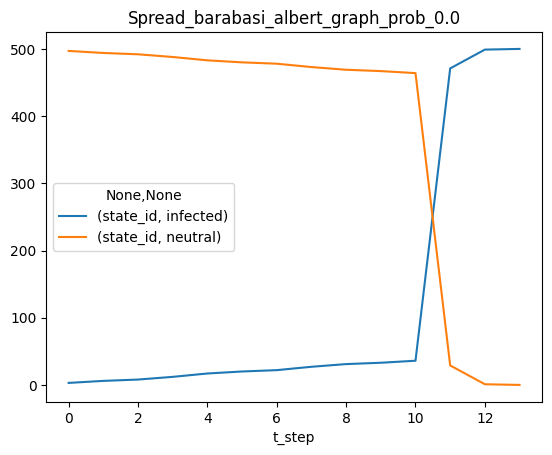

In [21]:
analysis.plot_all('soil_output/Spread_barabasi_albert_graph_prob_0.0/', analysis.get_count, 'state_id');

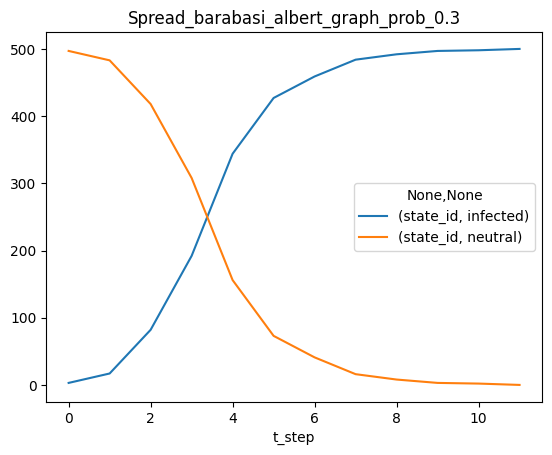

In [22]:
analysis.plot_all('soil_output/Spread_barabasi_albert_graph_prob_0.3/', analysis.get_count, 'state_id');

You can use wildcards in the results path:

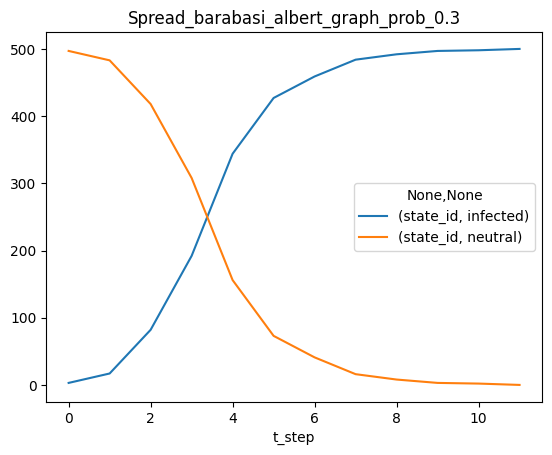

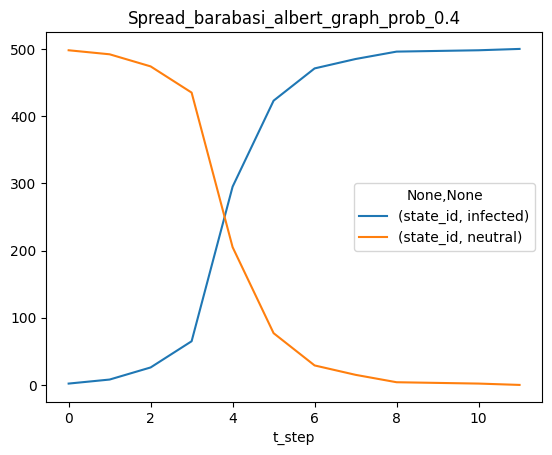

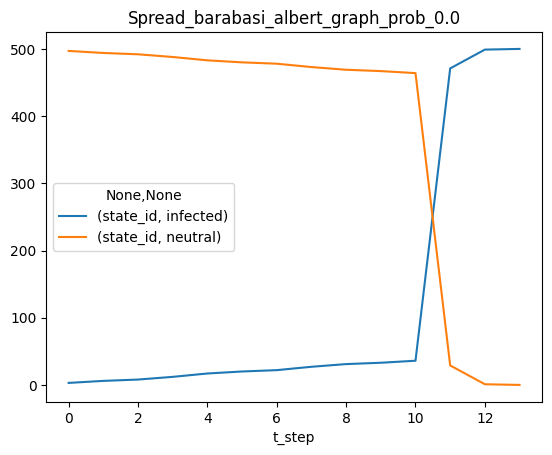

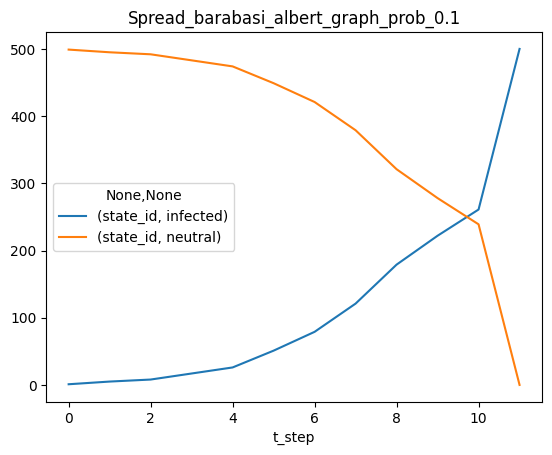

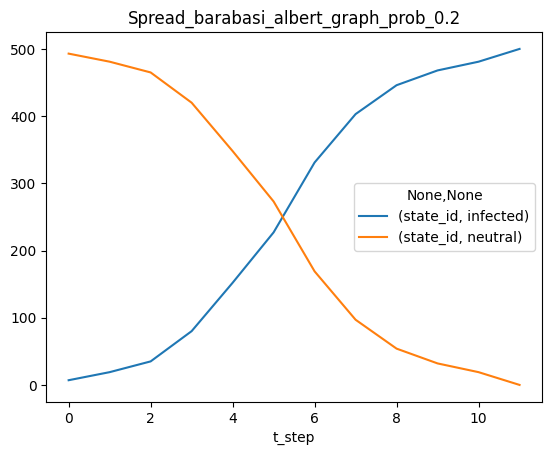

In [23]:
analysis.plot_all('soil_output/Spread_barabasi*/', analysis.get_count, 'state_id');

If we compare these results to those of the other graph model (a fully-connected graph), we can see a stark difference:

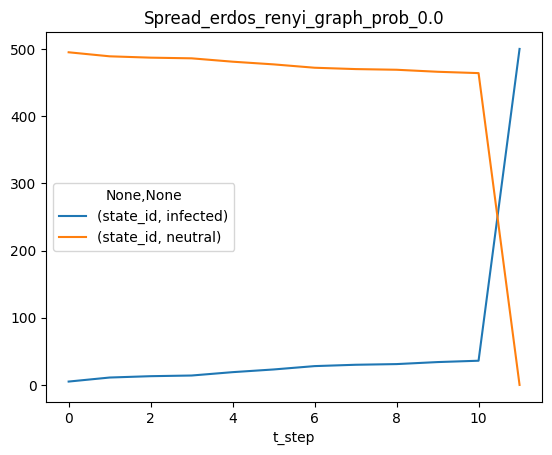

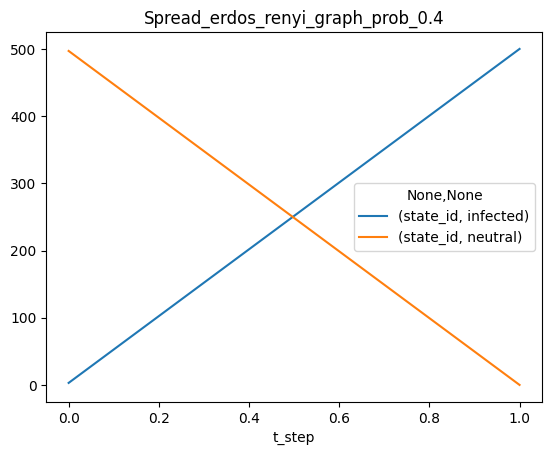

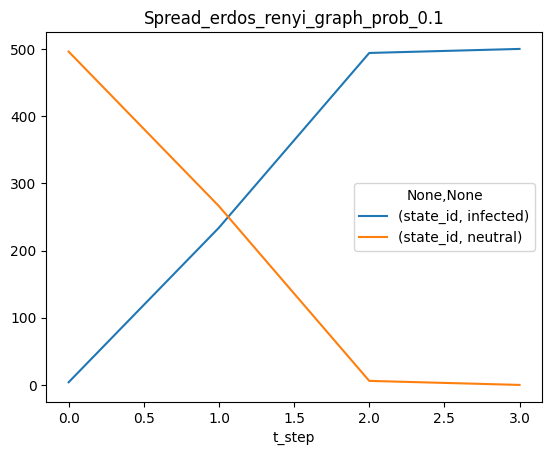

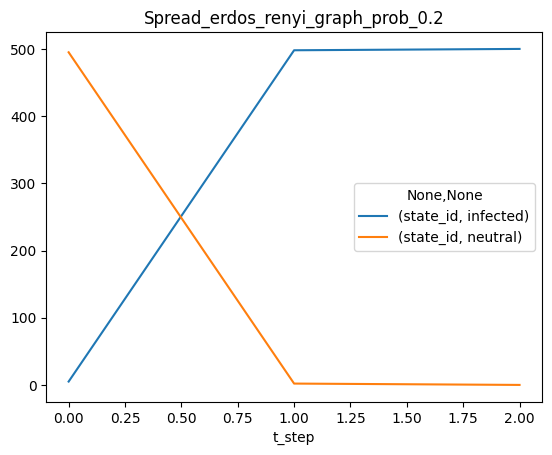

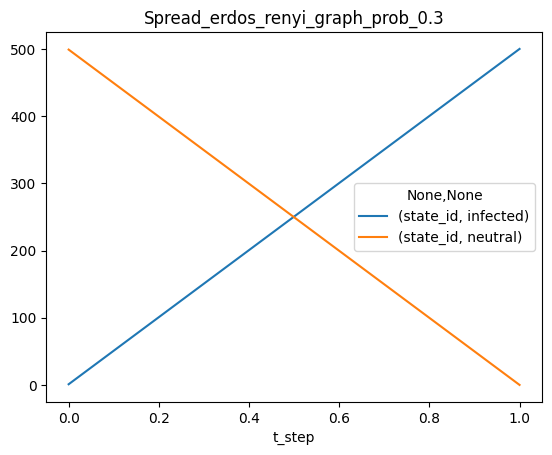

In [24]:
analysis.plot_all('soil_output/Spread_erdos*', analysis.get_count, 'state_id');

The previous cells were using the `count_value` function for aggregation. There's another function to plot numeral values:

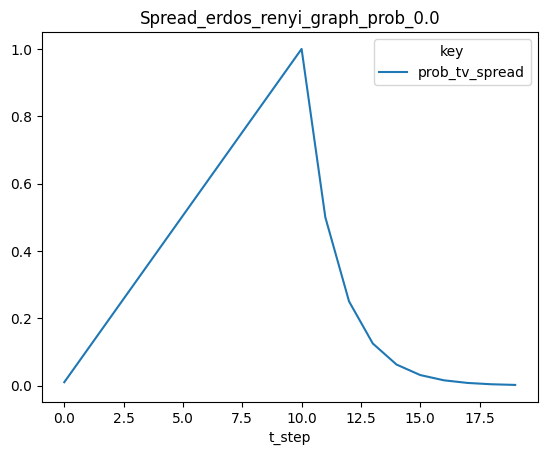

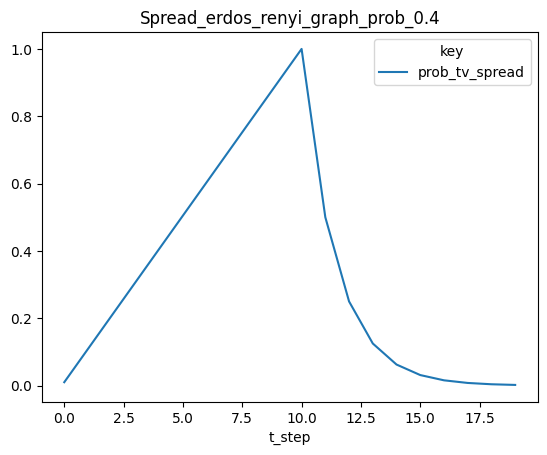

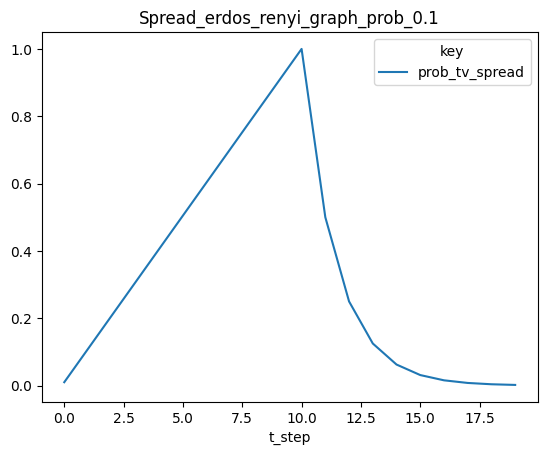

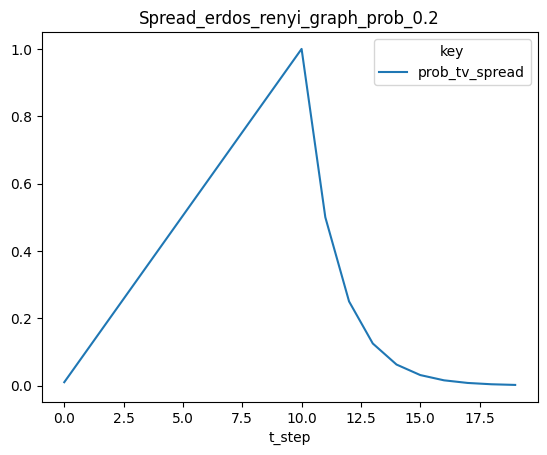

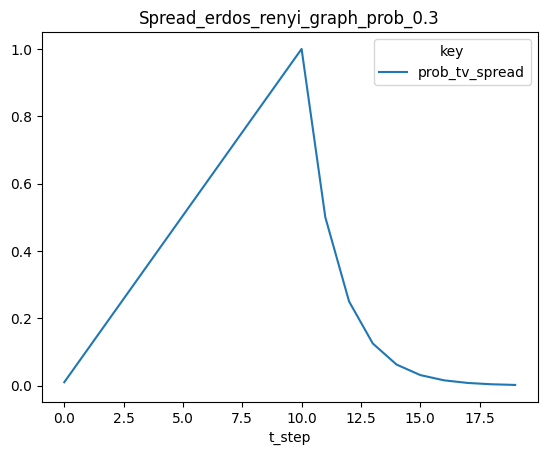

In [25]:
analysis.plot_all('soil_output/Spread_erdos*', analysis.get_value, 'prob_tv_spread');

### Manually plotting with pandas

Although the simplest way to visualize the results of a simulation is to use the built-in methods in the analysis module, sometimes the setup is more complicated and we need to explore the data a little further.

For that, we can use native pandas over the results.

Soil provides some convenience methods to simplify common operations:

* `analysis.split_df` to separate a history dataframe into environment and agent parameters.
* `analysis.get_count` to get a dataframe with the value counts for different attributes during the simulation.
* `analysis.get_value` to get the evolution of the value of an attribute during the simulation.

And, as we saw earlier, `analysis.process` can turn a dataframe in canonical form into a dataframe with a column per attribute.


In [26]:
!ls soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0*

soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0.dumped.yml
soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0.sqlite
soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.csv
soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.sqlite
soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.stats.csv


In [27]:
df = analysis.read_sql('soil_output/Spread_barabasi_albert_graph_prob_0.0/Spread_barabasi_albert_graph_prob_0.0_trial_0.sqlite')
df

key                                               SEED alive              \
dict_id                                            env     0     1    10   
t_step                                                                     
0.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
1.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
2.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
3.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
4.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
5.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
6.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
7.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
8.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
9.0      Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
10.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
11.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
12.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
13.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
14.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
15.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
16.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
17.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
18.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   
19.0     Spread_barabasi_albert_graph_prob_0.0_trial_0  True  True  True   

key                                          ...  state_id            \
dict_id   100   101   102   103   104   105  ...        90        91   
t_step                                       ...                       
0.0      True  True  True  True  True  True  ...   neutral   neutral   
1.0      True  True  True  True  True  True  ...   neutral   neutral   
2.0      True  True  True  True  True  True  ...   neutral   neutral   
3.0      True  True  True  True  True  True  ...   neutral   neutral   
4.0      True  True  True  True  True  True  ...   neutral   neutral   
5.0      True  True  True  True  True  True  ...   neutral   neutral   
6.0      True  True  True  True  True  True  ...   neutral   neutral   
7.0      True  True  True  True  True  True  ...   neutral   neutral   
8.0      True  True  True  True  True  True  ...   neutral   neutral   
9.0      True  True  True  True  True  True  ...   neutral   neutral   
10.0     True  True  True  True  True  True  ...   neutral   neutral   
11.0     True  True  True  True  True  True  ...  infected  infected   
12.0     True  True  True  True  True  True  ...  infected  infected   
13.0     True  True  True  True  True  True  ...  infected  infected   
14.0     True  True  True  True  True  True  ...  infected  infected   
15.0     True  True  True  True  True  True  ...  infected  infected   
16.0     True  True  True  True  True  True  ...  infected  infected   
17.0     True  True  True  True  True  True  ...  infected  infected   
18.0     True  True  True  True  True  True  ...  infected  infected   
19.0     True  True  True  True  True  True  ...  infected  infected   

key                                                                            \
dict_id        92        93        94        95        96        97        98   
t_step                                                                          
0.0       neutral   neutral   neutral   neutral   neutral   neutral   neutral   
1.0       neutral   neutral   neutral   neutral   neutral   neutral   neutral   
2.0       neutral   neutral   neutral   neutral   neutral   neutral   neutral   
3.0       neutral   neutral   neutral   neutral   neutral   neutral   neutral   
4.0       neutral   neutral

Let's look at the evolution of agent parameters in the simulation

<Axes: xlabel='t_step'>

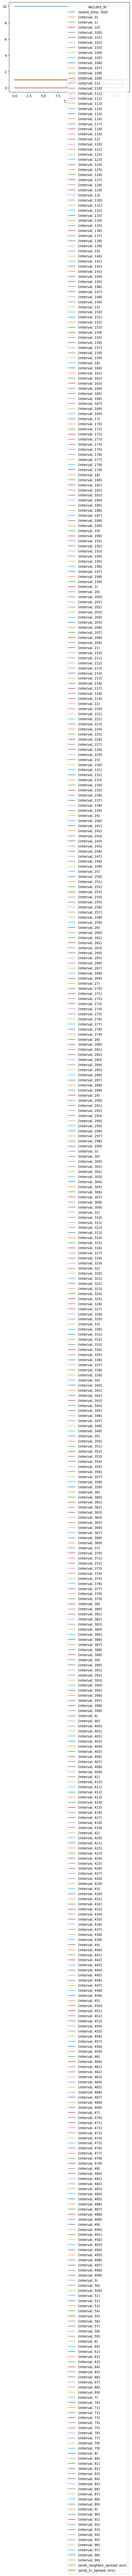

In [28]:
df.plot()

As we can see, `event_time` and `interval` are cluttering our results, 

<Axes: xlabel='t_step'>

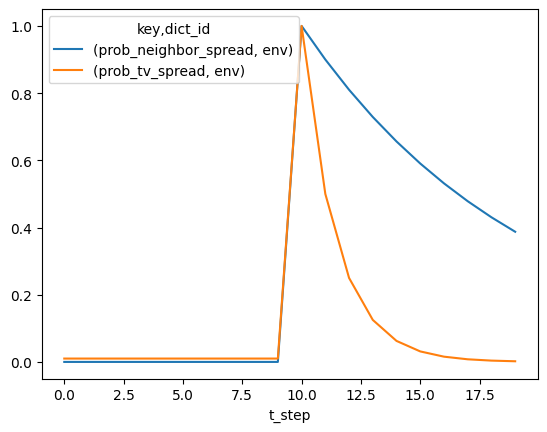

In [29]:
del df['interval']
del df['event_time']
df.plot()

The `soil.analysis` module also provides convenient functions to count the number of agents in a given state:

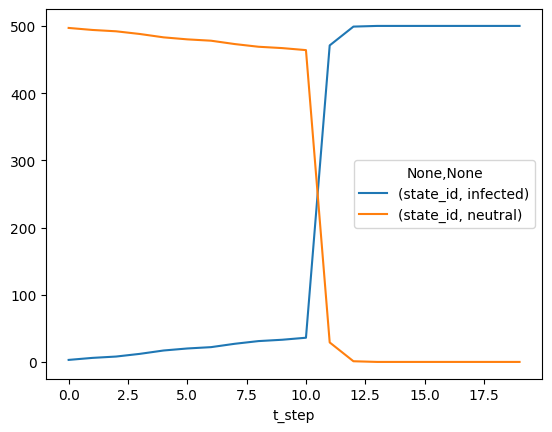

In [30]:
analysis.get_count(agents, 'state_id').plot();

## Dealing with bigger data

In [31]:
from soil import analysis

In [32]:
!du -xsh ../rabbits/soil_output/rabbits_example/

1.1M	../rabbits/soil_output/rabbits_example/


If we tried to load the entire history, we would probably run out of memory. Hence, it is recommended that you also specify the attributes you are interested in.

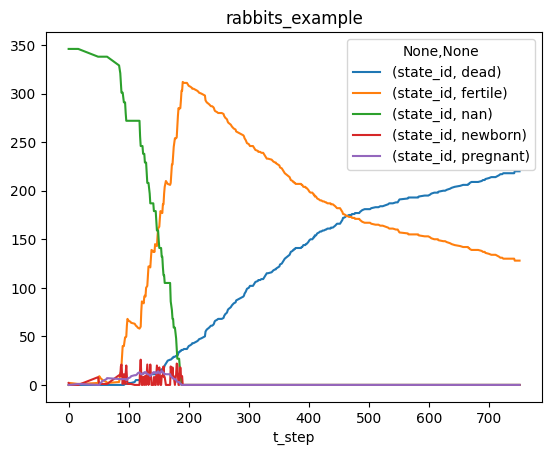

In [33]:
p = analysis.plot_all('../rabbits/soil_output/rabbits_example/', analysis.get_count, 'state_id')

In [34]:
!ls ../rabbits/soil_output/rabbits_example

backup			    rabbits_example.sqlite
rabbits_example.dumped.yml  rabbits_example_trial_0.sqlite


In [35]:
df = analysis.read_sql('../rabbits/soil_output/rabbits_example/rabbits_example_trial_0.sqlite', keys=['state_id', 'rabbits_alive'])

In [36]:
df

key     rabbits_alive  state_id                                               \
dict_id           env         0        1    10   100      101   102      103   
t_step                                                                         
0.0                 0   newborn  newborn   nan   nan      nan   nan      nan   
2.0                 0   fertile  fertile   nan   nan      nan   nan      nan   
16.0                0  pregnant  fertile   nan   nan      nan   nan      nan   
49.0                8   fertile  fertile   nan   nan      nan   nan      nan   
51.0                8   fertile  fertile   nan   nan      nan   nan      nan   
...               ...       ...      ...   ...   ...      ...   ...      ...   
739.0              15   fertile     dead  dead  dead  fertile  dead  fertile   
742.0              14   fertile     dead  dead  dead  fertile  dead  fertile   
743.0              12   fertile     dead  dead  dead  fertile  dead  fertile   
744.0              10   fertile     dead  dead  dead  fertile  dead  fertile   
751.0               9   fertile     dead  dead  dead  fertile  dead  fertile   

key                  ...                                                  \
dict_id   104   105  ...    90       91    92    93    94       95    96   
t_step               ...                                                   
0.0       nan   nan  ...   nan      nan   nan   nan   nan      nan   nan   
2.0       nan   nan  ...   nan      nan   nan   nan   nan      nan   nan   
16.0      nan   nan  ...   nan      nan   nan   nan   nan      nan   nan   
49.0      nan   nan  ...   nan      nan   nan   nan   nan      nan   nan   
51.0      nan   nan  ...   nan      nan   nan   nan   nan      nan   nan   
...       ...   ...  ...   ...      ...   ...   ...   ...      ...   ...   
739.0    dead  dead  ...  dead  fertile  dead  dead  dead  fertile  dead   
742.0    dead  dead  ...  dead  fertile  dead  dead  dead  fertile  dead   
743.0    dead  dead  ...  dead  fertile  dead  dead  dead  fertile  dead   
744.0    dead  dead  ...  dead  fertile  dead  dead  dead  fertile  dead   
751.0    dead  dead  ...  dead  fertile  dead  dead  dead  fertile  dead   

key                        
dict_id    97    98    99  
t_step                     
0.0       nan   nan   nan  
2.0       nan   nan   nan  
16.0      nan   nan   nan  
49.0      nan   nan   nan  
51.0      nan   nan   nan  
...       ...   ...   ...  
739.0    dead  dead  dead  
742.0    dead  dead  dead  
743.0    dead  dead  dead  
744.0    dead  dead  dead  
751.0    dead  dead  dead  

[326 rows x 349 columns]

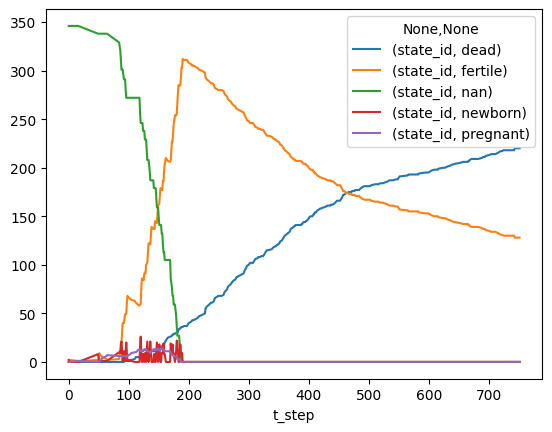

In [37]:
states = analysis.get_count(df, 'state_id')
states.plot();

<Axes: xlabel='t_step'>

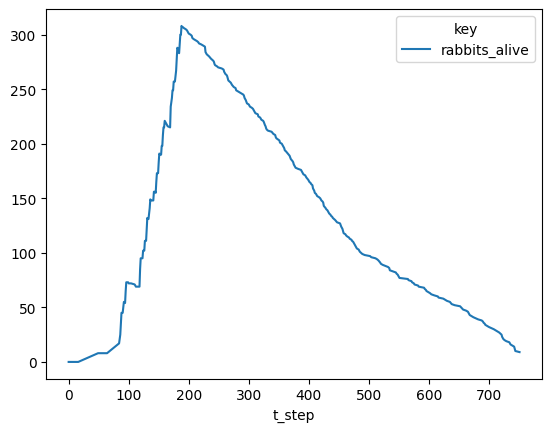

In [38]:
alive = analysis.get_value(df, 'rabbits_alive', aggfunc='sum').apply(pd.to_numeric)
alive.plot()

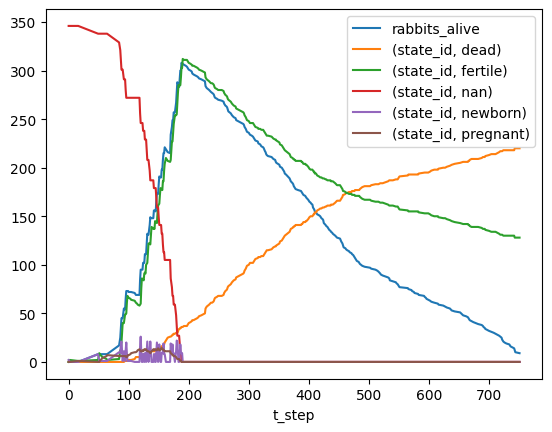

In [39]:
h = pd.concat([alive, states]);
h.plot();